In [2]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [3]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer01p1.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [4]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
        
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s
            
    return spike_rate

def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces
    
SAVE_PROGRESS(HISTORY_FILEPATH)  

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer01p1_2024-05-10.py


In [5]:
# basic plot functions
def raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)

def stim_time_stamp_axvline(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvline(tstamp_start, color = facecolor_strs[i_step])
            plt.axvline(tstamp_end, color = facecolor_strs[i_step])
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.40 s


In [6]:
def draw_orientation_symbol(size, orientation_rad, offset_xy, plot_ax = None):
    # rot_matrix = np.array([[1, 0], [0, 1]])*np.cos(orientation_rad) + np.array([[0, -1],[1, 0]])*np.sin(orientation_rad)
    rot_matrix = np.array([[1, 0], [0, 1]])*np.cos(-orientation_rad) + np.array([[0, -1],[1, 0]])*np.sin(-orientation_rad)
    
    base_plot_v_line_xys = np.array([[-0.2,-1], [-0.2,1]]) 
    base_plot_h_line_xys = np.array([[-0.2,0],[1,0]])

    base_plot_v_line_xys = base_plot_v_line_xys * size 
    base_plot_h_line_xys = base_plot_h_line_xys * size 

    base_plot_v_line_xys = base_plot_v_line_xys @ rot_matrix
    base_plot_h_line_xys = base_plot_h_line_xys @ rot_matrix

    base_plot_v_line_xys += offset_xy.reshape((1,-1))
    base_plot_h_line_xys += offset_xy.reshape((1,-1))

    if plot_ax is None:
        plot_ax = plt.gca()

    plot_ax.plot(base_plot_v_line_xys[:,0], 
             base_plot_v_line_xys[:,1],
             color = "black")
    plot_ax.plot(base_plot_h_line_xys[:,0],
             base_plot_h_line_xys[:,1],
             color = "black")

def imshow_blank_stim_sequence(imshape, stim_tstamps, plot_ax = None):
    disp_vmin = 0
    disp_vmax = 1
    disp_cmap = "gray"
    
    stim_seq_img = np.zeros(imshape)
    nof_stims, nof_steps, nof_tstamp = stim_tstamps.shape
    
    stim_fill_vals = np.zeros((nof_stims, nof_steps))
    stim_fill_vals[:,1] = 1

    plot_orient_step = (2*np.pi)/nof_stims
    plot_orient_offet = 0
    # plot_orients = np.linspace(0, 360, nof_stims)
    plot_orients = plot_orient_offet + np.arange(nof_stims) * plot_orient_step
    # print(plot_orients)
    
    for i_stim in range(nof_stims):
        for i_step in range(nof_steps):
            tstamp_start, tstamp_end = stim_tstamps[i_stim, i_step, :]
            tstamp_start = max(tstamp_start, 0)
            tstamp_end = min(tstamp_end, imshape[-1])
            if tstamp_end < tstamp_start:
                continue
            stim_seq_img[:, tstamp_start:tstamp_end] = stim_fill_vals[i_stim, i_step]

    if plot_ax is None:
        plot_ax = plt.gca()
    
    plot_ax.imshow(stim_seq_img, 
               cmap = disp_cmap,
               vmin = disp_vmin,
               vmax = disp_vmax,
               interpolation = "none",
               aspect = "auto")
    plot_ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    
    for i_stim in range(nof_stims):
        tstamp_start, tstamp_end = stim_tstamps[i_stim, 1, :]
        tstamp_start = max(tstamp_start, 0)
        tstamp_end = min(tstamp_end, imshape[-1])
        if tstamp_end < tstamp_start:
            continue
        draw_orientation_symbol(imshape[0]/2, 
                                plot_orients[i_stim],
                                np.array([(tstamp_start + tstamp_end)/2, imshape[0]/2]),
                                plot_ax,
                               )
    plot_ax.set_xlim(left = 0, 
                     right = imshape[1]
                    )
    plot_ax.set_ylim(bottom = 0, 
                     top = imshape[0]
                    )

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.41 s


In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl_colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.42 s


In [8]:
# create customized colormap

truncate_pink = truncate_colormap(plt.get_cmap("pink"), 0.2, 1)
truncate_gray = truncate_colormap(plt.get_cmap("gray"), 0.2, 1)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.43 s


In [9]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

full_page_figure_illustrator_size_pxls = np.array([521, 655])
full_page_paper_illustrator_size_pxls = np.array([620, 801])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls


SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.44 s


In [10]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

# bw_order = 12
# bw_cutoff = 50

bw_order = 5
bw_cutoff = 20

fs = 1 * s_to_ms / time_per_frame_ms

real_period_s = 1.0109
ideal_period_s = 1
real_timing_correct_ratio = real_period_s/ideal_period_s

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.45 s


[  0.  45.  90. 135. 180. 225. 270. 315.]
1.0
(8, 3, 2)
Time since last sync = 15.52 s


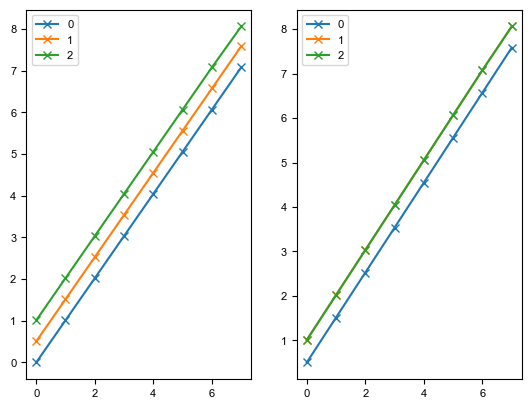

In [11]:
# ordered visual stimulation configuration (only works for one repetition)
ideal_static_moving_t_s = np.array([0.5, 0.5, 0])
# ideal_static_moving_t_s = np.array([0.25, 0.75, 0]) # updated blank and stimulation calculation time stamps
# ideal_static_moving_t_s = np.array([0.25, 0.5, 0.25])

# correct timing from statistical analysis of the record result
static_moving_t_s = ideal_static_moving_t_s

nof_orient = 8

orient_angles_deg = np.arange(nof_orient) * (360/nof_orient)
orient_angles_rad = orient_angles_deg * (np.pi/180)
 
print(orient_angles_deg)

# conversion
nof_stim_steps = static_moving_t_s.size
tot_trail_t_s = np.sum(static_moving_t_s)

view_stim_tstamp_s = np.zeros((nof_orient, nof_stim_steps, 2))

cur_start_t_s = np.arange(nof_orient) * tot_trail_t_s
for i_step in range(nof_stim_steps):
    view_stim_tstamp_s[:, i_step, 0] = cur_start_t_s
    cur_start_t_s = cur_start_t_s + static_moving_t_s[i_step]
    view_stim_tstamp_s[:, i_step, 1] = cur_start_t_s

print(tot_trail_t_s)
print(view_stim_tstamp_s.shape)

# view_stim_tstamp_s = 0.25 + view_stim_tstamp_s # updated blank and stimulation calculation time stamps

view_stim_tstamp_s = view_stim_tstamp_s * real_timing_correct_ratio

# view_stim_tstamp_s[view_stim_tstamp_s > 8] = 8 # updated blank and stimulation calculation time stamps
view_stim_tstamp_s[view_stim_tstamp_s > (3100-1)*2.6*1E-3] = (3100-1)*2.6*1E-3 # updated blank and stimulation calculation time stamps

plt.figure()
for i in range(2):
    plt.subplot(1,2,i + 1)
    for i_step in range(nof_stim_steps):
        plt.plot(view_stim_tstamp_s[:,i_step,i], "-x", label = f"{i_step}")
    plt.legend()
    
view_stim_tstamp = (view_stim_tstamp_s * s_to_ms)/time_per_frame_ms
view_stim_tstamp = view_stim_tstamp.astype(int)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

In [28]:
# src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_Good\stats_analysis_data.hdf5"
# src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW\stats_analysis_data.hdf5"
# src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming\stats_analysis_data.hdf5"

src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\stats_analysis_data.hdf5"
# src_hdf5_file_path = r"M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\stats_analysis_data.hdf5"


dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "figures_tmp"

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\StimResponsePlotVer01p1_2024-05-10.py


In [29]:
# load source data 

nof_rois = None
nof_trials = None
nof_frames = None
nof_orient = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_vec_sum_ang = None
snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None


with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
    print(hdf5_file["src_sub_dir_name"][()])
    
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_vec_sum_ang[i_roi] = hdf5_file[os.path.join(cur_roi_str, "vec_sum_complex.ang")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

b'VolpyResults_Ver01'
Time since last sync = 13.23 s


In [30]:
print(t_test_pass_mask.size)
print(np.sum(t_test_pass_mask))
print(np.sum(diff_t_test_pass_mask))
print(np.sum(np.logical_and(t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(t_test_pass_mask, diff_anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, diff_anova_test_pass_mask)))

SAVE_PROGRESS(HISTORY_FILEPATH)

202
77
100
63
76
24
26
Time since last sync = 13.24 s


In [31]:
# generate test mask for displaying data

test_mask = diff_t_test_pass_mask
# test_mask = np.logical_and(test_mask,anova_test_pass_mask)

print(np.sum(test_mask))
print(repr(np.where(test_mask)))

masked_spike_events = roi_spike_events[test_mask, :, :]
masked_subthd_dFFs = roi_subthd_dFFs[test_mask, :, :]
masked_dFFs = dFF_s[test_mask,:,:]
masked_vec_sum_angle = roi_vec_sum_ang[test_mask]
masked_t_s = t_s[test_mask,:,:]
masked_F0_s = F0_s[test_mask,:,:]
masked_raw_dFFs = raw_dFFs[test_mask,:,:]

print(masked_spike_events.shape)
print(masked_subthd_dFFs.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

100
(array([  3,  10,  11,  16,  17,  23,  25,  26,  29,  31,  33,  37,  39,
        40,  41,  43,  45,  48,  51,  53,  55,  57,  58,  62,  64,  65,
        71,  72,  74,  75,  76,  77,  79,  80,  82,  83,  84,  85,  87,
        88,  90,  91,  92,  93,  95,  96,  97,  98, 104, 105, 106, 107,
       108, 109, 110, 111, 113, 116, 117, 121, 123, 125, 126, 127, 128,
       129, 130, 131, 136, 138, 139, 141, 143, 144, 145, 146, 148, 150,
       154, 155, 158, 159, 161, 163, 168, 171, 172, 176, 177, 181, 182,
       183, 184, 185, 192, 193, 197, 198, 199, 201], dtype=int64),)
(100, 37, 3100)
(100, 37, 3100)
Time since last sync = 13.50 s


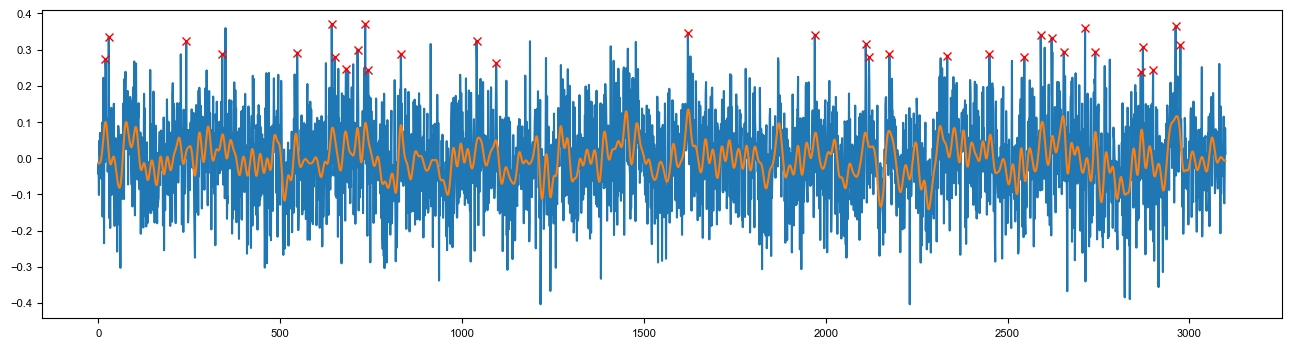

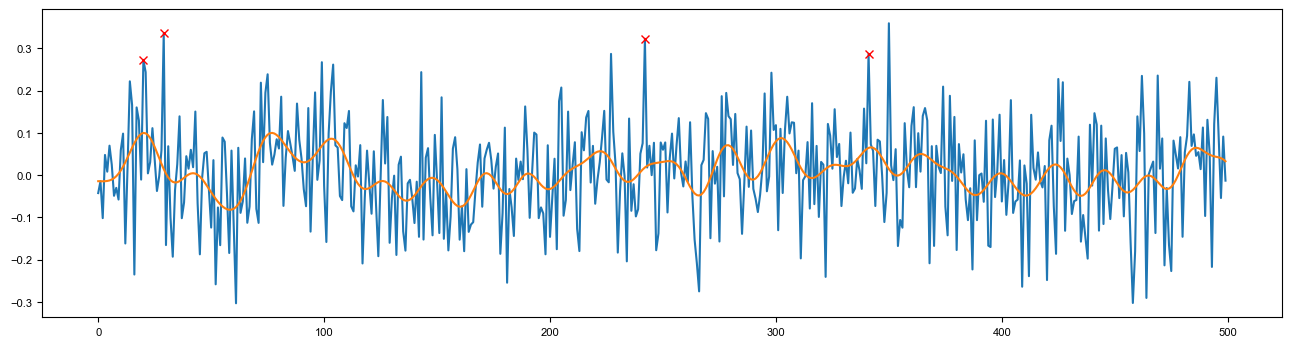

Time since last sync = 13.98 s


In [32]:
# check loaded data
check_i_roi = 32
check_i_trial = 1

plot_x_range = [300, 800]


check_dFF =  dFF_s[check_i_roi, check_i_trial, :]
check_dFF_subthd = roi_subthd_dFFs[check_i_roi, check_i_trial, :]
check_spike_mask = roi_spike_events[check_i_roi, check_i_trial, :]

plot_xs = np.arange(len(check_dFF))

plot_spike_xs = plot_xs.copy().astype(float)
plot_spike_ys = check_dFF.copy().astype(float)
plot_spike_xs[check_spike_mask <= 0] = np.nan
plot_spike_ys[check_spike_mask <= 0 ] = np.nan
# plot_spike_xs = plot_xs[check_spike_mask > 0]
# plot_spike_ys = check_dFF[check_spike_mask > 0]

plt.figure(figsize = (16,4))
plt.plot(plot_xs, check_dFF)
plt.plot(plot_xs, check_dFF_subthd)
plt.plot(plot_spike_xs, plot_spike_ys, "rx")
plt.show()

zoom_x_range = np.arange(0, 500)
plt.figure(figsize = (16,4))
plt.plot(plot_xs[zoom_x_range], check_dFF[zoom_x_range])
plt.plot(plot_xs[zoom_x_range], check_dFF_subthd[zoom_x_range])
plt.plot(plot_spike_xs[zoom_x_range], plot_spike_ys[zoom_x_range], "rx")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [33]:
# tmp basic plot functions
def tmp_raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 2,
                 linewidths = 2)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 14.00 s


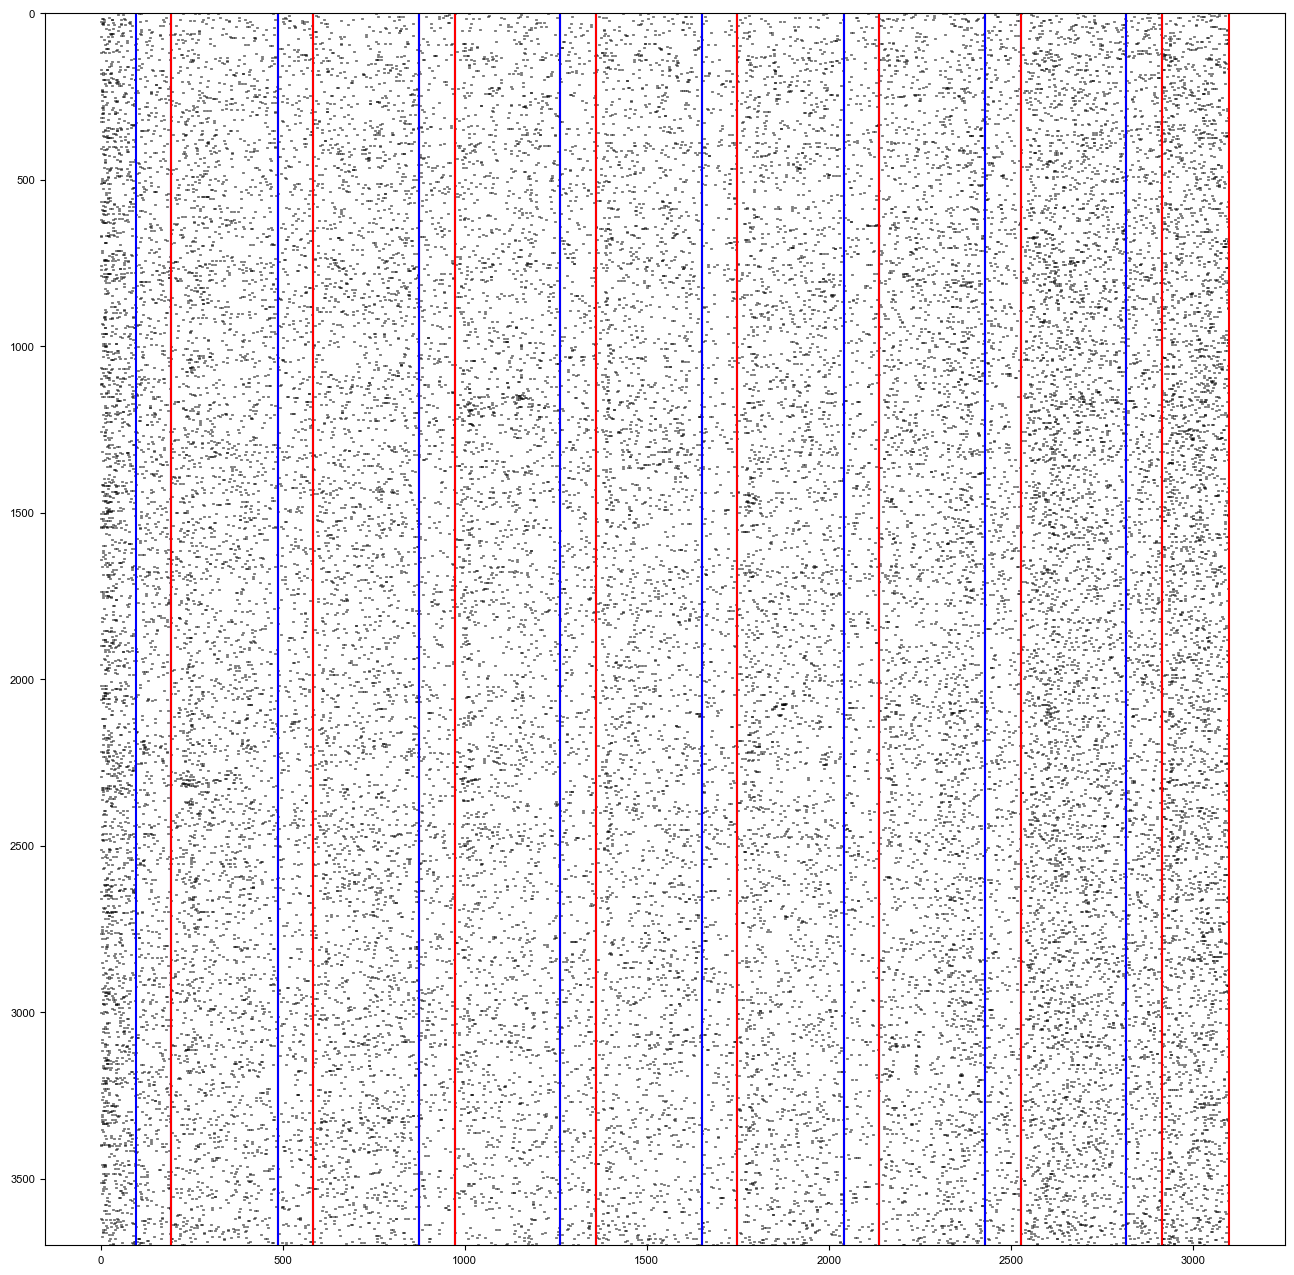

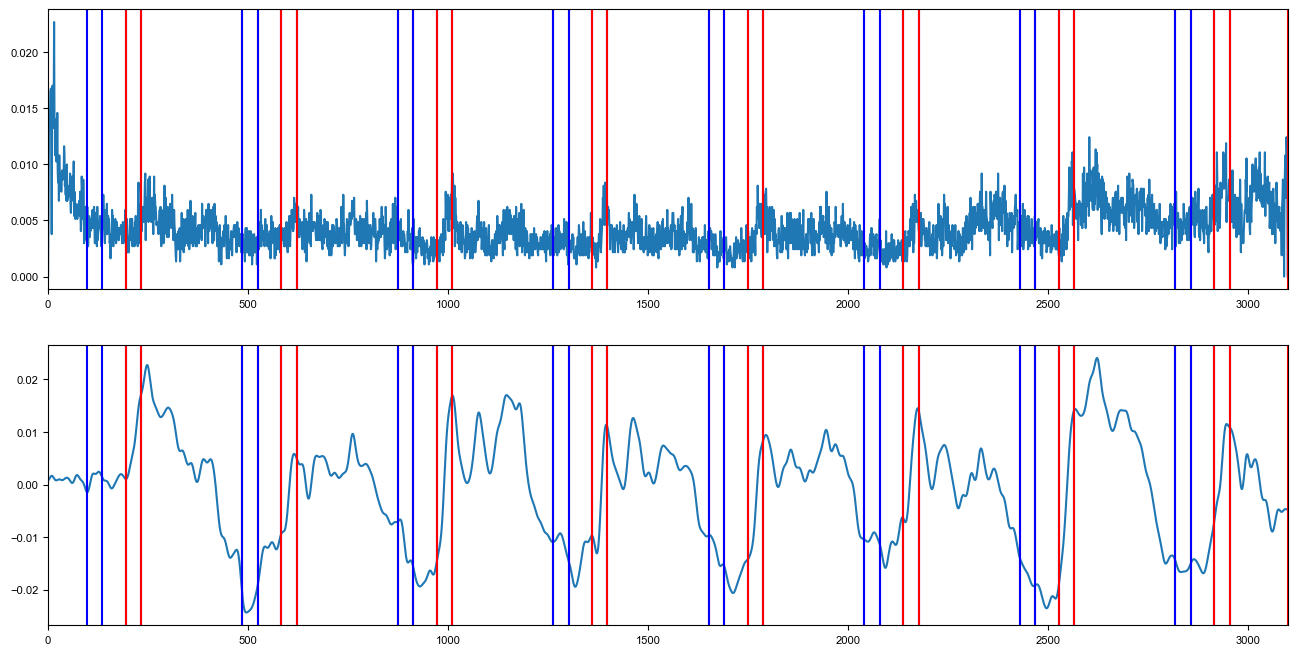

Time since last sync = 17.81 s


In [34]:
# check spike raster and subthreshold dF/F 
plt.figure(figsize = (16,16))
# plt.imshow(masked_subthd_dFFs.reshape((-1,nof_frames)),
#            cmap = "pink_r",
#            vmin = -0.05,
#            vmax = 0.12,
#            # alpha = 1,
#            aspect = "auto",
#           )
tmp_raster_plot(masked_spike_events.reshape((-1, nof_frames)))
# plt.colorbar(orientation = "horizontal",
#             location = "top")
stim_time_stamp_axvline(stim_tstamp)
plt.ylim([np.prod(masked_subthd_dFFs.shape[:-1]), 0])
plt.show()

plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(np.mean(masked_spike_events, axis = (0,1)))
plt.xlim([0, masked_spike_events.shape[-1]])
stim_time_stamp_axvline(stim_tstamp)
stim_time_stamp_axvline(stim_tstamp + 100/2.6)
plt.subplot(2,1,2)
plt.plot(np.mean(masked_subthd_dFFs, axis = (0,1)))
plt.xlim([0, masked_subthd_dFFs.shape[-1]])
stim_time_stamp_axvline(stim_tstamp)
stim_time_stamp_axvline(stim_tstamp + 100/2.6)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

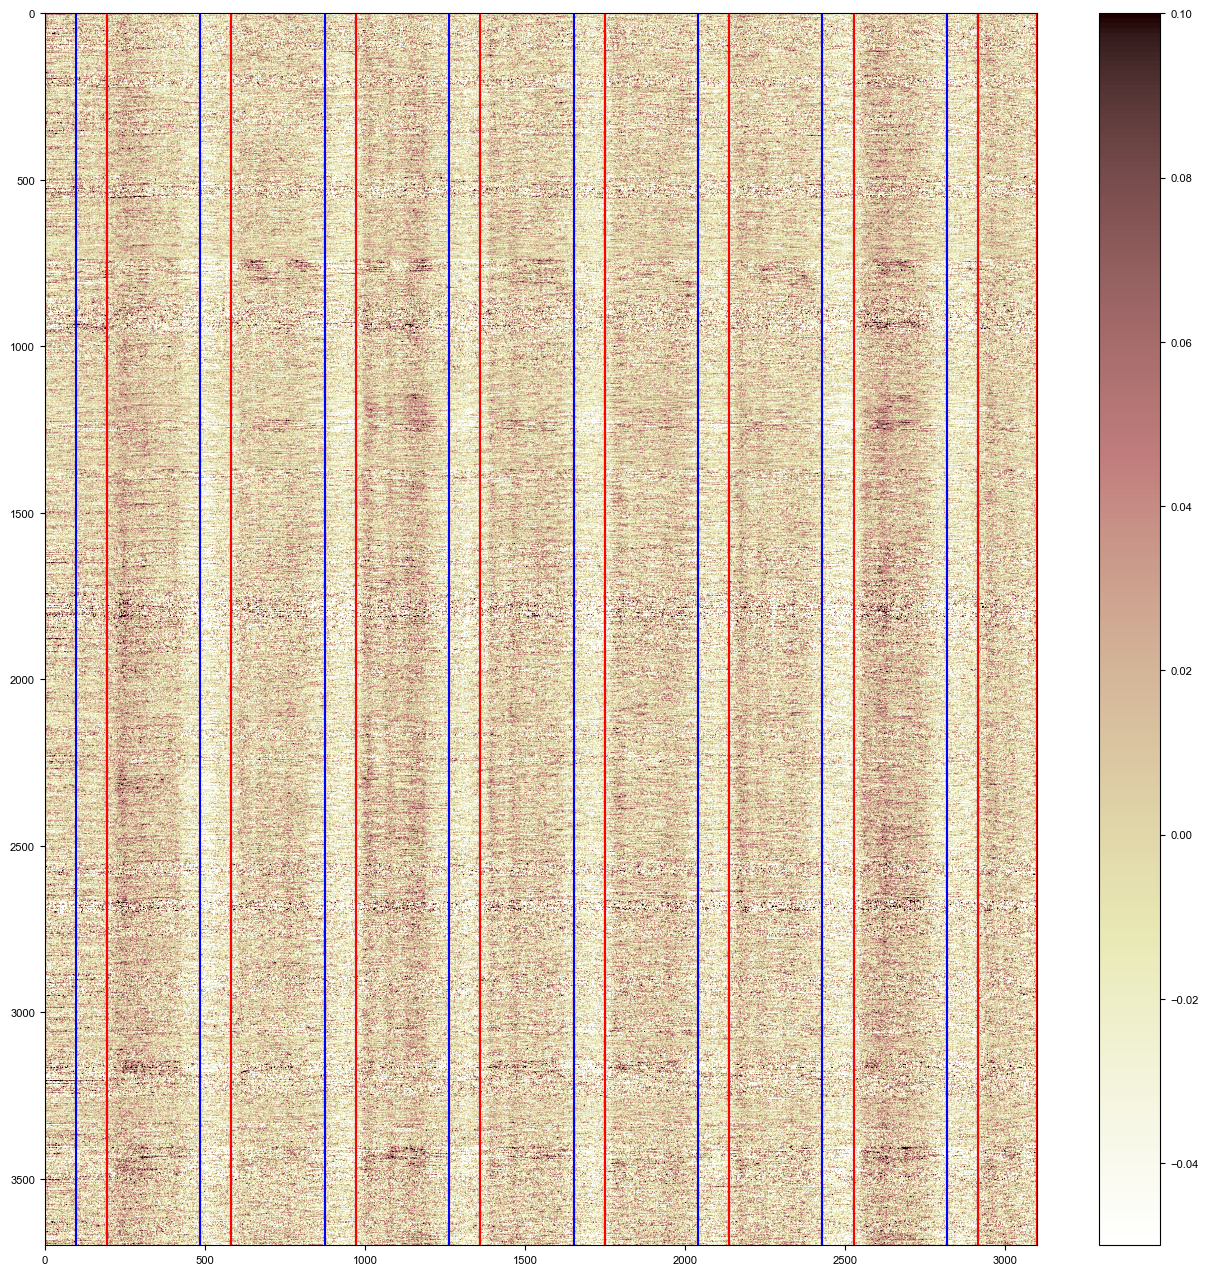

Time since last sync = 37.92 s


In [18]:
# check dF/F 

plt.figure(figsize = (16,16))
plt.imshow(masked_dFFs.reshape((-1,nof_frames)),
           cmap = "pink_r",
           vmin = -0.05,
           vmax = 0.1,
           # alpha = 0.5,
           aspect = "auto",
          )
plt.colorbar()
# raster_plot(masked_spike_events.reshape((-1, nof_frames)))
stim_time_stamp_axvline(stim_tstamp)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [16]:
dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures
Time since last sync = 70.64 s


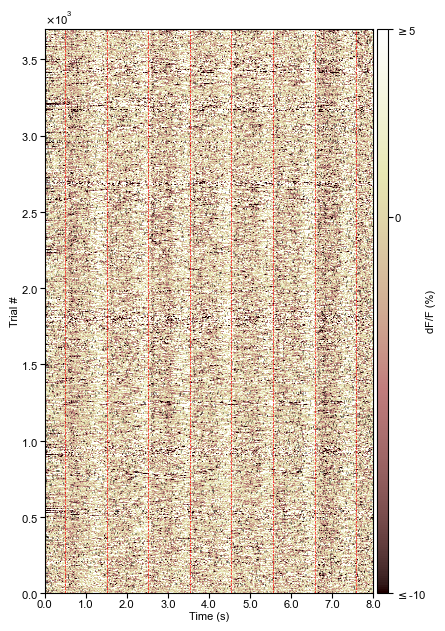

Time since last sync = 21.30 s


In [20]:
# make (nice) all trial 

plot_font_size = 8

plot_vmin = -0.10
plot_vmax = +0.05

# plot_cmap = "gray"
plot_cmap = "pink"
# plot_cmap = "Greens"
# plot_spike_color = "red"
plot_spike_color = "black"

plot_spike_events = masked_spike_events.reshape((-1, masked_spike_events.shape[-1]))
plot_subthd_dFFs = -masked_subthd_dFFs.reshape((-1, masked_subthd_dFFs.shape[-1]))
plot_stim_tstamps = stim_tstamp

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

fig_width = letter_paper_size_inch[0] * (19/32)
fig_height = letter_paper_size_inch[1] * (2/3)

dst_figure_name = f"all_VE_cell_raster_plot"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height))

plot_ax = plt.gca()

plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = plot_cmap,
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.01, 
                    aspect = 50,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 
cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "Arial", labelpad = 0)

plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

for i_orint in range(plot_stim_tstamps.shape[0]):
    plt.axvline(plot_stim_tstamps[i_orint,1,0], 
                linestyle = "--", 
                color = "red",
                linewidth = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Trial #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3), useMathText=True,)
plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

# fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
# fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
# fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

# with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
#     pickle.dump(fig, dst_pkl_file)

# with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
#     hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
#     hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
#     hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
#     hdf5_file.create_dataset("plt_xs", data = plt_xs)
#     for i_elem in range(len(event_xs)):
#         hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
#     hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
#     hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)
#     hdf5_file.create_dataset("plot_stim_tstamps", data = plot_stim_tstamps)

# %notebook $dst_notebook_path
                             
# print("plot saved to: " + dst_pdf_figure_path)
# print("pickle dump to: " + dst_pkl_figure_path)
# print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_stimblank_seq_ver01.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_stimblank_seq_ver01.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_stimblank_seq_ver01.hdf5


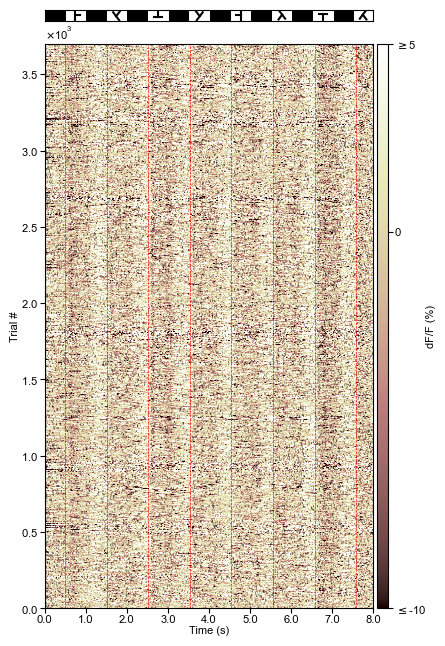

Time since last sync = 90.57 s


In [20]:
# make (nice) all trial 

plot_font_size = 8

plot_vmin = -0.10
plot_vmax = +0.05

# plot_cmap = "gray"
plot_cmap = "pink"
# plot_cmap = "Greens"
# plot_spike_color = "red"
plot_spike_color = "black"

plot_spike_events = masked_spike_events.reshape((-1, masked_spike_events.shape[-1]))
plot_subthd_dFFs = -masked_subthd_dFFs.reshape((-1, masked_subthd_dFFs.shape[-1]))
plot_stim_tstamps = stim_tstamp

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_blank_stim_seq_tstamps = view_stim_tstamp
plot_blank_stim_seq_shape = np.array([80, plot_subthd_dFFs.shape[-1]])
plot_blank_stim_seq_inset_axis_bounds = np.array([0, 1.04, 1, 0.02])

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

fig_width = letter_paper_size_inch[0] * (19/32)
fig_height = letter_paper_size_inch[1] * (2/3)

dst_figure_name = f"all_VE_cell_raster_plot_with_stimblank_seq_ver01"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height))

plot_ax = plt.gca()

plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = plot_cmap,
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.01, 
                    aspect = 50,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 
cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "Arial", labelpad = 0)

plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

for i_orint in range(plot_stim_tstamps.shape[0]):
    plt.axvline(plot_stim_tstamps[i_orint,1,0], 
                linestyle = "--", 
                color = "red",
                linewidth = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Trial #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3), useMathText=True,)
plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

plot_inset_ax = plot_ax.inset_axes(plot_blank_stim_seq_inset_axis_bounds)
imshow_blank_stim_sequence(plot_blank_stim_seq_shape,
                           plot_blank_stim_seq_tstamps,
                           plot_inset_ax)


fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 600)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
    hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
    hdf5_file.create_dataset("plt_xs", data = plt_xs)
    for i_elem in range(len(event_xs)):
        hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
    hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
    hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)
    hdf5_file.create_dataset("plot_stim_tstamps", data = plot_stim_tstamps)
    hdf5_file.create_dataset("plot_blank_stim_seq_tstamps", data = plot_blank_stim_seq_tstamps)
    hdf5_file.create_dataset("plot_blank_stim_seq_shape", data = plot_blank_stim_seq_shape)
    hdf5_file.create_dataset("plot_blank_stim_seq_inset_axis_bounds", data = plot_blank_stim_seq_inset_axis_bounds)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_orient_seq_truncate_pink_short.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_orient_seq_truncate_pink_short.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_orient_seq_truncate_pink_short.hdf5


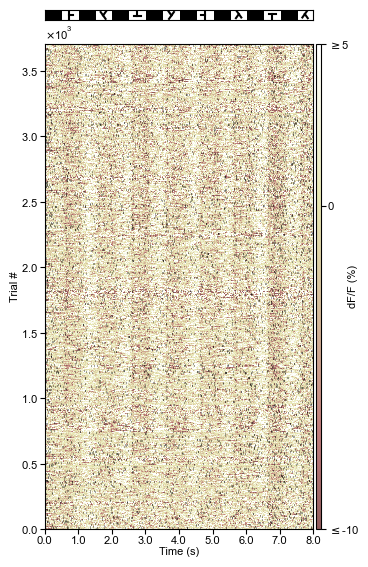

Time since last sync = 135.48 s


In [31]:
# make (nice) all trial with orientation squence

plot_font_size = 8

plot_vmin = -0.10
plot_vmax = +0.05

# plot_cmap = "gray"
# plot_cmap = "pink"
plot_cmap = truncate_pink
# plot_cmap = "Greens"
# plot_spike_color = "red"
plot_spike_color = "black"

plot_spike_events = masked_spike_events.reshape((-1, masked_spike_events.shape[-1]))
plot_subthd_dFFs = -masked_subthd_dFFs.reshape((-1, masked_subthd_dFFs.shape[-1]))
plot_stim_tstamps = stim_tstamp

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

plot_blank_stim_seq_tstamps = view_stim_tstamp
plot_blank_stim_seq_shape = np.array([80, plot_subthd_dFFs.shape[-1]])

# fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (19/32)
# fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (2/3)

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (1/2)
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (3/4)

dst_figure_name = f"all_VE_cell_raster_plot_with_orient_seq_truncate_pink_short"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height))

# gs = mpl_gridspec.GridSpec(2, 2, height_ratios=[1,50], width_ratios=[50,1], 
#                            hspace = 0.08, wspace=0.02)
gs = mpl_gridspec.GridSpec(2, 2, height_ratios=[1,50], width_ratios=[50,1], 
                           hspace = 0.1, wspace=0.02)

plot_ax = plt.gca()

plot_ax = plt.subplot(gs[1,0])
plot_img = plt.imshow(plot_subthd_dFFs,
                       aspect = "auto",
                       interpolation = "none",
                       cmap = plot_cmap,
                       vmin = plot_vmin,
                       vmax = plot_vmax,
                       alpha = 1,
                      )

plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

# for i_orint in range(plot_stim_tstamps.shape[0]):
#     plt.axvline(plot_stim_tstamps[i_orint,1,0], 
#                 linestyle = "--", 
#                 color = "red",
#                 linewidth = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Trial #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3), useMathText=True,)
plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

plot_ax = plt.subplot(gs[1,1])
cbar = plt.colorbar(
                    plot_img,
                    cax = plot_ax, 
                    # location = "right",
                    pad=0.01, 
                    aspect = 50,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )

cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 
cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "Arial", labelpad = -8)

plot_ax = plt.subplot(gs[0,0])
imshow_blank_stim_sequence(plot_blank_stim_seq_shape,
                           plot_blank_stim_seq_tstamps)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 600)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
    hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
    hdf5_file.create_dataset("plt_xs", data = plt_xs)
    for i_elem in range(len(event_xs)):
        hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
    hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
    hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)
    hdf5_file.create_dataset("plot_stim_tstamps", data = plot_stim_tstamps)
    hdf5_file.create_dataset("plot_blank_stim_seq_tstamps", data = plot_blank_stim_seq_tstamps)
    hdf5_file.create_dataset("plot_blank_stim_seq_shape", data = plot_blank_stim_seq_shape)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714]


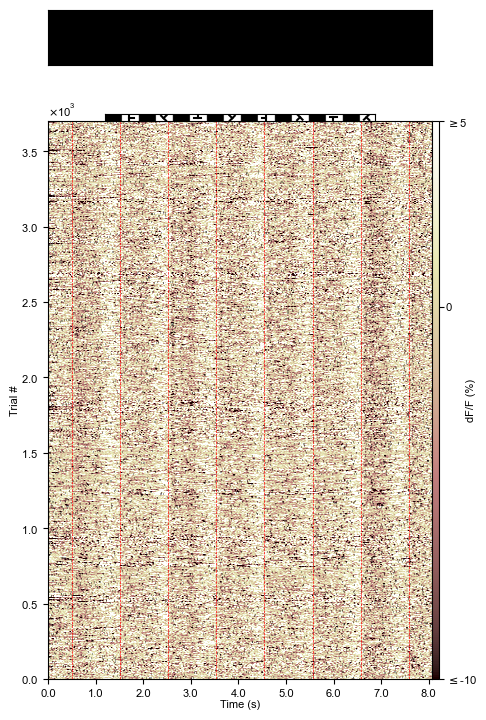

Time since last sync = 108.66 s


In [91]:
# inset axis test code

plot_font_size = 8

plot_vmin = -0.10
plot_vmax = +0.05

# plot_cmap = "gray"
plot_cmap = "pink"
# plot_cmap = "Greens"
# plot_spike_color = "red"
plot_spike_color = "black"

plot_spike_events = masked_spike_events.reshape((-1, masked_spike_events.shape[-1]))
plot_subthd_dFFs = -masked_subthd_dFFs.reshape((-1, masked_subthd_dFFs.shape[-1]))
plot_stim_tstamps = stim_tstamp

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

plot_blank_stim_seq_tstamps = view_stim_tstamp
plot_blank_stim_seq_shape = np.array([80, plot_subthd_dFFs.shape[-1]])

fig_width = letter_paper_size_inch[0] * (19/32)
fig_height = letter_paper_size_inch[1] * (2/3)

dst_figure_name = f"all_VE_cell_raster_plot_with_orient_seq_test"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height))

gs = mpl_gridspec.GridSpec(1, 1, figure = fig)

cur_subplot_gs = mpl_gridspec.GridSpecFromSubplotSpec(2, 2, 
                                                      height_ratios=[1,80], width_ratios=[50,1], 
                                                      hspace = 0, wspace=0,
                                                      subplot_spec=gs[0])

plot_ax = plt.gca()




plot_ax = fig.add_subplot(cur_subplot_gs[1,0])
plot_img = plot_ax.imshow(plot_subthd_dFFs,
                       aspect = "auto",
                       interpolation = "none",
                       cmap = plot_cmap,
                       vmin = plot_vmin,
                       vmax = plot_vmax,
                       alpha = 1,
                      )
# plot_ax.imshow(np.zeros((40, plot_subthd_dFFs.shape[-1])),
#                aspect = "auto",
#                cmap = "gray")

# plot_ax = fig.add_subplot(cur_subplot_gs[1,0],
#                      frameon = False)
# plot_ax = plot_ax.twinx()
plot_ax = plot_ax.inset_axes([0, 1.1, 1, 0.1])

# test_subplot_arr = np.full((plot_subthd_dFFs.shape[0] + 1000, plot_subthd_dFFs.shape[-1]), np.nan)
# test_subplot_arr[plot_subthd_dFFs.shape[0]:, :] = 0
test_subplot_arr = np.zeros((100,  plot_subthd_dFFs.shape[-1]))
plot_ax.imshow(test_subplot_arr,
               aspect = "auto",
               cmap = "gray")
plot_ax.xaxis.set_visible(False)
plot_ax.yaxis.set_visible(False)


plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

for i_orint in range(plot_stim_tstamps.shape[0]):
    plt.axvline(plot_stim_tstamps[i_orint,1,0], 
                linestyle = "--", 
                color = "red",
                linewidth = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
# plt.xlim(left = plot_x_ticks[0],
#          right = plot_x_ticks[-1])
plt.xlim(left = 0,
                right = plot_spike_events.shape[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Trial #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3), useMathText=True,)
plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

plot_ax = plt.subplot(cur_subplot_gs[1,1])
cbar = plt.colorbar(
                    plot_img,
                    cax = plot_ax, 
                    # location = "right",
                    pad=0.01, 
                    aspect = 50,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )

cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 
cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "Arial", labelpad = -8)

plot_ax = plt.subplot(cur_subplot_gs[0,0])
imshow_blank_stim_sequence(plot_blank_stim_seq_shape,
                           plot_blank_stim_seq_tstamps)

# fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
# fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
# fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

# with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
#     pickle.dump(fig, dst_pkl_file)

# with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
#     hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
#     hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
#     hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
#     hdf5_file.create_dataset("plt_xs", data = plt_xs)
#     for i_elem in range(len(event_xs)):
#         hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
#     hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
#     hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)
#     hdf5_file.create_dataset("plot_stim_tstamps", data = plot_stim_tstamps)
#     hdf5_file.create_dataset("plot_blank_stim_seq_tstamps", data = plot_blank_stim_seq_tstamps)
#     hdf5_file.create_dataset("plot_blank_stim_seq_shape", data = plot_blank_stim_seq_shape)

# %notebook $dst_notebook_path
                             
# print("plot saved to: " + dst_pdf_figure_path)
# print("pickle dump to: " + dst_pkl_figure_path)
# print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_stimblank_seq_ver01_split.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_stimblank_seq_ver01_split.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\all_VE_cell_raster_plot_with_stimblank_seq_ver01_split.hdf5


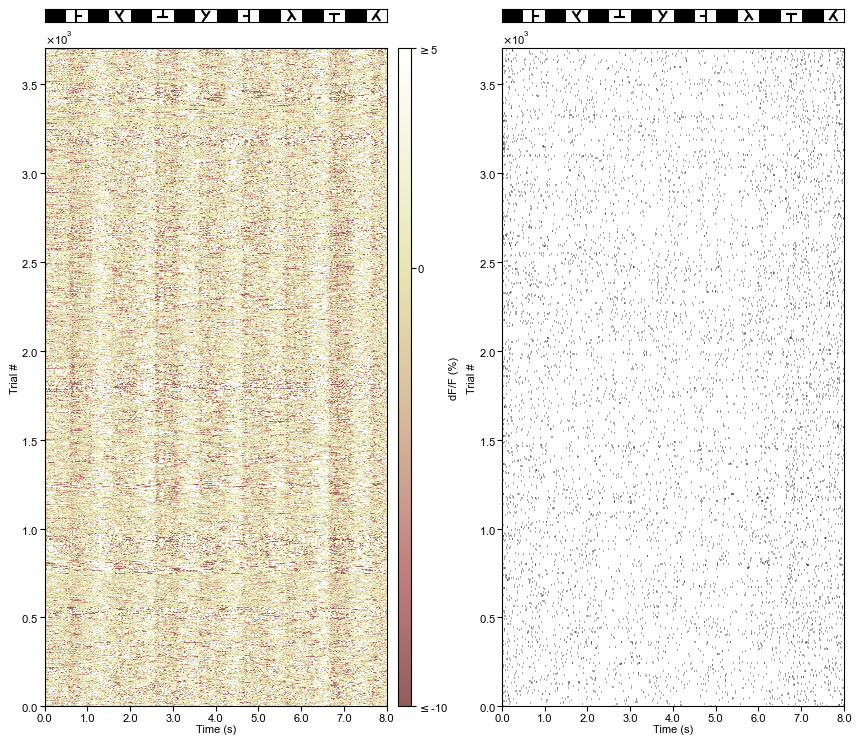

Time since last sync = 178.46 s


In [22]:
# make (nice) all trial 

plot_font_size = 8

plot_vmin = -0.10
plot_vmax = +0.05

# plot_cmap = "gray"
# plot_cmap = "pink"
plot_cmap = truncate_pink
# plot_cmap = "Greens"
# plot_spike_color = "red"
plot_spike_color = "black"

plot_spike_events = masked_spike_events.reshape((-1, masked_spike_events.shape[-1]))
plot_subthd_dFFs = -masked_subthd_dFFs.reshape((-1, masked_subthd_dFFs.shape[-1]))
plot_stim_tstamps = stim_tstamp

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_blank_stim_seq_tstamps = view_stim_tstamp
plot_blank_stim_seq_shape = np.array([80, plot_subthd_dFFs.shape[-1]])
plot_blank_stim_seq_inset_axis_bounds = np.array([0, 1.04, 1, 0.02])

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

fig_width = letter_paper_size_inch[0] * (1)
fig_height = letter_paper_size_inch[1] * (2/3)

dst_figure_name = f"all_VE_cell_raster_plot_with_stimblank_seq_ver01_split"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height), layout = "constrained")

gs = mpl_gridspec.GridSpec(1,2, figure = fig)

plt.subplot(gs[0,0])

plot_ax = plt.gca()

plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = plot_cmap,
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.01, 
                    aspect = 50,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 
cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "Arial", labelpad = 0)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Trial #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3), useMathText=True,)
plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

plot_inset_ax = plot_ax.inset_axes(plot_blank_stim_seq_inset_axis_bounds)
imshow_blank_stim_sequence(plot_blank_stim_seq_shape,
                           plot_blank_stim_seq_tstamps,
                           plot_inset_ax)

plt.subplot(gs[0,1])
plot_ax = plt.gca()

plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

# for i_orint in range(plot_stim_tstamps.shape[0]):
#     plt.axvline(plot_stim_tstamps[i_orint,1,0], 
#                 linestyle = "--", 
#                 color = "red",
#                 linewidth = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Trial #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3), useMathText=True,)
plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

plot_inset_ax = plot_ax.inset_axes(plot_blank_stim_seq_inset_axis_bounds)
imshow_blank_stim_sequence(plot_blank_stim_seq_shape,
                           plot_blank_stim_seq_tstamps,
                           plot_inset_ax)


fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 600)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
    hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
    hdf5_file.create_dataset("plt_xs", data = plt_xs)
    for i_elem in range(len(event_xs)):
        hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
    hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
    hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)
    hdf5_file.create_dataset("plot_stim_tstamps", data = plot_stim_tstamps)
    hdf5_file.create_dataset("plot_blank_stim_seq_tstamps", data = plot_blank_stim_seq_tstamps)
    hdf5_file.create_dataset("plot_blank_stim_seq_shape", data = plot_blank_stim_seq_shape)
    hdf5_file.create_dataset("plot_blank_stim_seq_inset_axis_bounds", data = plot_blank_stim_seq_inset_axis_bounds)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)